# DORA single dataset analysis

In [1]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np
from analyse import *


df = pd.read_excel("./data/5EA-Séance1.xlsx")
df.head() 

,Unnamed: 0,61e6cece123b33069fe67847_pos_x,61e6cece123b33069fe67847_pos_y,61e6cece123b33069fe67847_ts,61e6cedb123b33069fe67848_pos_x,61e6cedb123b33069fe67848_pos_y,61e6cedb123b33069fe67848_ts
0,0,2.182682,48.812380,106638,2.182945,48.812710,104944
1,1,2.183085,48.812392,107074,2.182907,48.812515,105179
2,2,2.183105,48.812372,107718,2.182907,48.812515,105294
3,3,2.182877,48.812478,108391,2.182907,48.812515,106153
4,4,2.183085,48.812392,108624,2.182907,48.812515,106269


In [2]:
# Select which student to analyze
STUDENT = "61e6cece123b33069fe67847"

## Data cleaning

interactive(children=(IntSlider(value=5, description='max_dist', max=20, min=1), IntSlider(value=5, descriptio…

<function __main__.update(max_dist, dup_thresh)>

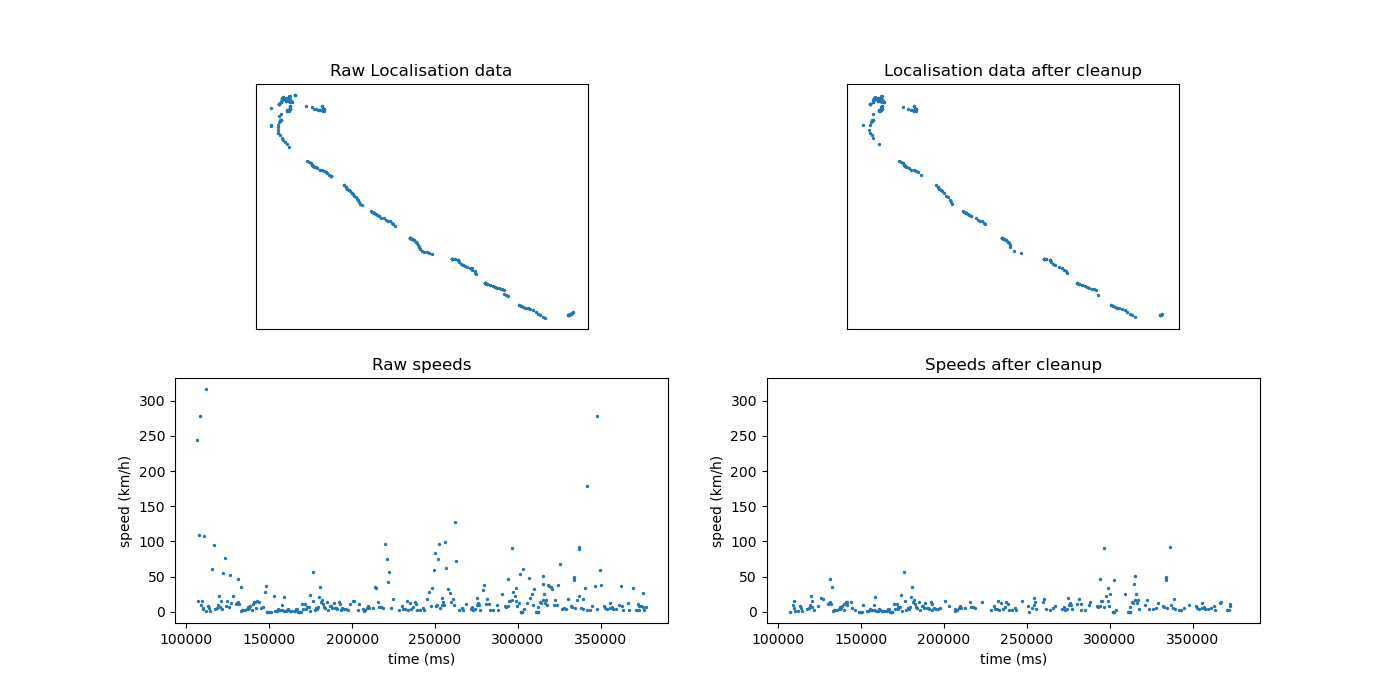

In [3]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [14, 7] # set default figure size

from ipywidgets import widgets

# combine eteh data from the lat, long and ts columns into a signe array of tuples and remove the 0 values
def get_data(df, student):
    arr = list(zip(df[student + '_pos_y'], df[student + '_pos_x'], df[student + '_ts']))
    arr = [val for val in arr if val[0] and val[1]] 
    return arr

positions = get_data(df, STUDENT) 
clean_positions = None
# Define initial parameters
init_incorrect = 3
init_dup = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(2, 2)
line = ax[0][0].scatter([n[1] for n in positions], [n[0] for n in positions], s=2)
ax[0][0].get_xaxis().set_visible(False)
ax[0][0].get_yaxis().set_visible(False)
ax[0][0].set_title("Raw Localisation data")
ax[0][0].set(aspect='equal')


clean_line = ax[0][1].scatter([n[1] for n in positions], [n[0] for n in positions], s=2)
clean_line.set_offsets(positions)
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].get_yaxis().set_visible(False)
ax[0][1].set_title("Localisation data after cleanup")
ax[0][1].set(aspect='equal')


speed_line = ax[1][0].scatter([n[2] for n in positions][:-1], speeds(positions), s=2)
ax[1][0].set_xlabel("time (ms)")
ax[1][0].set_ylabel("speed (km/h)")
ax[1][0].set_title("Raw speeds")

clean_speed_line = ax[1][1].scatter([n[2] for n in positions][:-1], speeds(positions), s=2)
ax[1][1].set_xlabel("time (ms)")
ax[1][1].set_ylabel("speed (km/h)")
ax[1][1].set_title("Speeds after cleanup")

# The function to be called anytime a slider's value changes
def update(max_dist, dup_thresh):
    global clean_positions
    clean_positions = remove_duplicates(positions, dup_threshold=dup_thresh)
    clean_positions = remove_incorrect(clean_positions, max_radius=max_dist)
    # clean_line.set_ydata([n[0] for n in clean_positions])
    # clean_line.set_xdata([n[1] for n in clean_positions])
    clean_line.set_offsets([(p[1], p[0]) for p in clean_positions])
    # clean_speed_line.set_xdata([n[2] for n in clean_positions][:-1])
    # clean_speed_line.set_ydata(speeds(clean_positions))
    clean_speed_line.set_offsets(list(zip([n[2] for n in clean_positions][:-1], speeds(clean_positions))))
    fig.canvas.draw_idle()

widgets.interact(update,
    max_dist=widgets.IntSlider(min=1, max=20, step=1, value=5),
    dup_thresh=widgets.IntSlider(min=1, max=20, step=1, value=5))


In [4]:
BEACONS = [
    [1, 48.8124241, 2.1829787],
    [2, 48.8118271, 2.1830392],
    [3,	48.8112972,	2.1838760],
    [4,	48.8108945,	2.1851528]
]

beacons_df = pd.DataFrame(BEACONS, columns=["id", "lat", "lng"])
beacons_df

,id,lat,lng
0,1,48.812424,2.182979
1,2,48.811827,2.183039
2,3,48.811297,2.183876
3,4,48.810895,2.185153


In [5]:
# format the beacon data to feed into the evaluate_beacon() function
beacon_dict = [{"id": b[0], "name": b[0], "coords": [b[2], b[1]]} for b in BEACONS]

results = evaluate_beacon(clean_positions, beacon_dict, BEACON_RADIUS_M=8)
print(results)

# Copy the results to the dataframe
for beacon in results:
    for key, val in beacon.items():
        if key == "coords": continue
        beacons_df.loc[beacons_df['id'] == beacon["id"], key] = val
beacons_df

[{'id': 1, 'valided': True, 'name': 1, 'coords': [2.1829787, 48.8124241], 'avgSpeed': 7.284292252084527, 'time': 19.789, 'timestamp': 126863, 'index': 18, 'lap': None}, {'id': 2, 'valided': True, 'name': 2, 'coords': [2.1830392, 48.8118271], 'avgSpeed': 7.817624153400094, 'time': 131.458, 'timestamp': 238532, 'index': 133, 'lap': None}, {'id': 3, 'valided': True, 'name': 3, 'coords': [2.183876, 48.8112972], 'avgSpeed': 8.00112207122163, 'time': 186.972, 'timestamp': 294046, 'index': 171, 'lap': None}, {'id': 4, 'valided': False, 'name': 4, 'coords': [2.1851528, 48.8108945], 'avgSpeed': None, 'time': None, 'timestamp': 0, 'index': 0, 'lap': None}]


,id,lat,lng,valided,name,avgSpeed,time,timestamp,index,lap
0,1,48.812424,2.182979,True,1.0,7.284292,19.789,126863.0,18.0,NaN
1,2,48.811827,2.183039,True,2.0,7.817624,131.458,238532.0,133.0,NaN
2,3,48.811297,2.183876,True,3.0,8.001122,186.972,294046.0,171.0,NaN
3,4,48.810895,2.185153,False,4.0,NaN,NaN,0.0,0.0,NaN


## Map Projections

In [12]:
geojson_lines = []
end_time = clean_positions[-1][2]

# Create each line
for i in range(len(clean_positions) - 1):
    geojson_lines.append({
        "coordinates": [
            [clean_positions[i][1], clean_positions[i][0]],
            [clean_positions[i + 1][1], clean_positions[i + 1][0]],
        ],
        "dates": [clean_positions[i][2], clean_positions[i + 1][2]],
        "color": "red",
    })

# Create a feature from each line
features = [
    {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": line["coordinates"],
        },
        "properties": {
            "times": line["dates"],
            "style": {
                "color": line["color"],
                "weight": line["weight"] if "weight" in line else 5,
            },
        },
    }
    for line in geojson_lines
]

# Generate the beacon markers
for b in beacons_df[['id', 'lat', 'lng', 'timestamp', 'valided']].itertuples():\

    # Add a red marker for every beacon
    features.append({
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [b.lng, b.lat],
            },
            "properties": {
                "times": 0,
                'icon': 'circle', 'iconstyle': {'color': 'red', "radius": 10}
            },
        })
    
    # If the beacon was valided, add a green marker over the red one at the correct timestamp
    if b.valided:
        features.append({
                "type": "Feature",
                "geometry": {
                    "type": "Point",
                    "coordinates": [b.lng, b.lat],
                },
                "properties": {
                    "times": [b.timestamp],
                    'icon': 'circle', 'iconstyle': {'color': 'green', "radius": 10}
                },
            })


Pandas(Index=0, id=1, lat=48.8124241, lng=2.1829787, timestamp=126863.0, valided=True)
Pandas(Index=1, id=2, lat=48.8118271, lng=2.1830392, timestamp=238532.0, valided=True)
Pandas(Index=2, id=3, lat=48.8112972, lng=2.183876, timestamp=294046.0, valided=True)
Pandas(Index=3, id=4, lat=48.8108945, lng=2.1851528, timestamp=0.0, valided=False)


In [14]:

import folium.plugins as plugins

f = folium.Figure(width=1000, height=500)
m = folium.Map()
f.add_child(m)

geojson = plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="PT1S",
    add_last_point=False,
    transition_time=100,
    
).add_to(m)

m.fit_bounds(geojson.get_bounds())

f

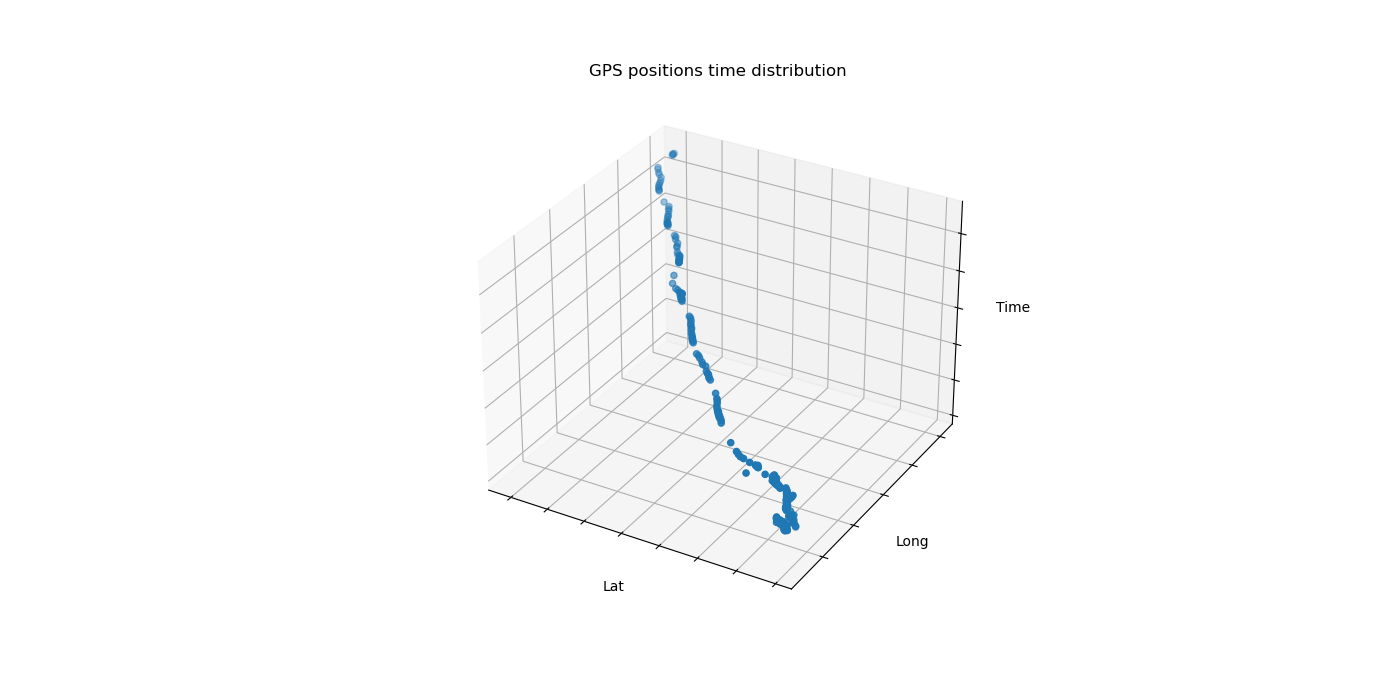

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = [p[0] for p in clean_positions]
ys = [p[1] for p in clean_positions]
zs = [p[2] for p in clean_positions]
ax.scatter(xs, ys, zs, marker='o')
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
ax.set_xlabel('Lat')
ax.set_ylabel('Long')
ax.set_zlabel('Time')
ax.set_title("GPS positions time distribution")

plt.show()